### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.set_printoptions(suppress=True)

from clonaltrans import pl, utils
import os

%load_ext autoreload
%autoreload 2

### Prediction Accuracy & Correlation with GroundTruth

Accuracy is displayed in 2 separate formats, the scaled input data (upper plot) and the raw data (lower plot).

The input data of this model is calculated by torch.pow(N, 1/4), which is the power of 1/4 of origianl data for numerical stability.

Correlation is the spearman correlation R.

In [3]:
path = './examples/clonetrans_model.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")

There are 3 observed timepoints except the inital time.


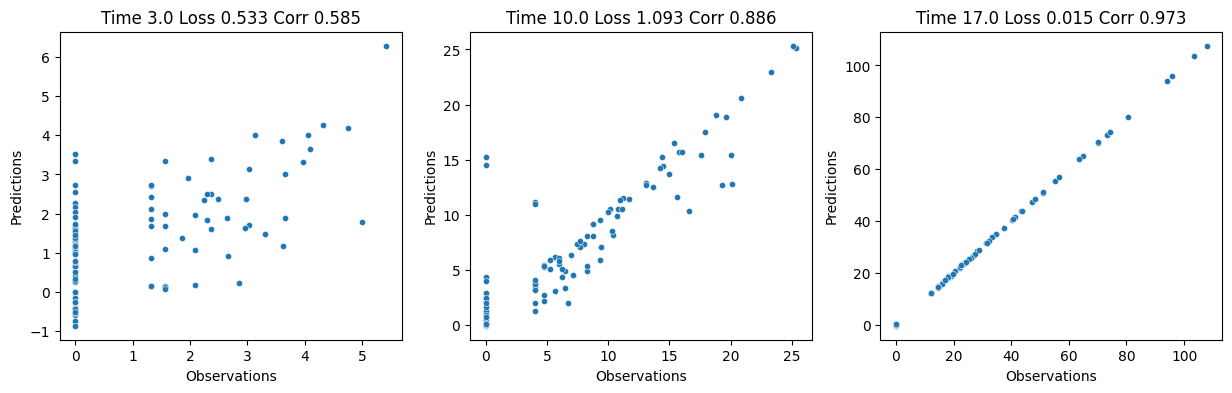

In [4]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)
t_observed_norm = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])
predictions = model.eval_model(t_observed_norm, log_output=False)

save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.input_N[1:], predictions[1:], t_observed[1:], save=False)

There are 3 observed timepoints except the inital time.


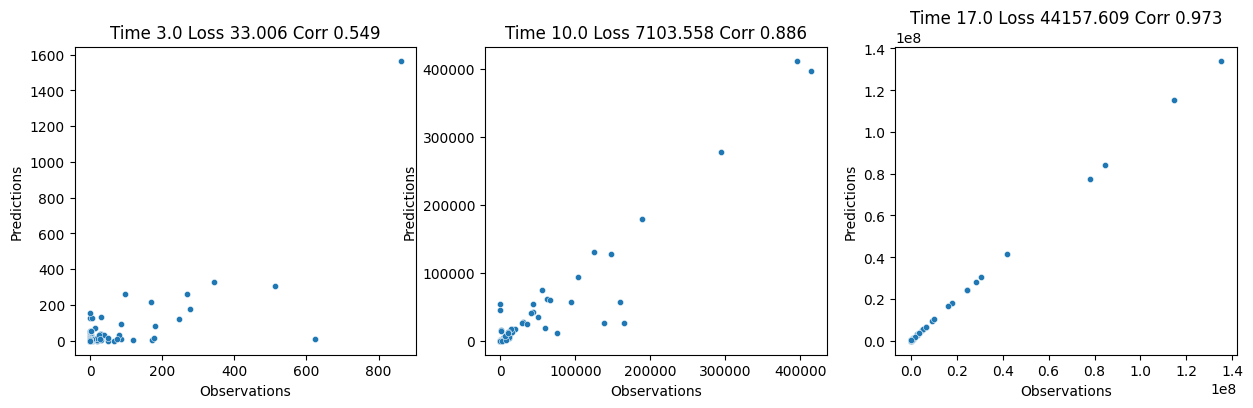

In [5]:
save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.N[1:], torch.pow(predictions[1:], 4), t_observed[1:], save=False)

### Smoothed trajectory from T0 -> T17

Same as above, upper plot shows scaled input result, and lower plot is result for raw data.

Trajectory is depicted using ODE parameters with 100 intermediate interpolations, plot for raw data is an approximate mapping based on transition rate K between 2 modes.

In [6]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)

x = np.linspace(0, 17, 100)
t_pred = torch.tensor(x).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm)

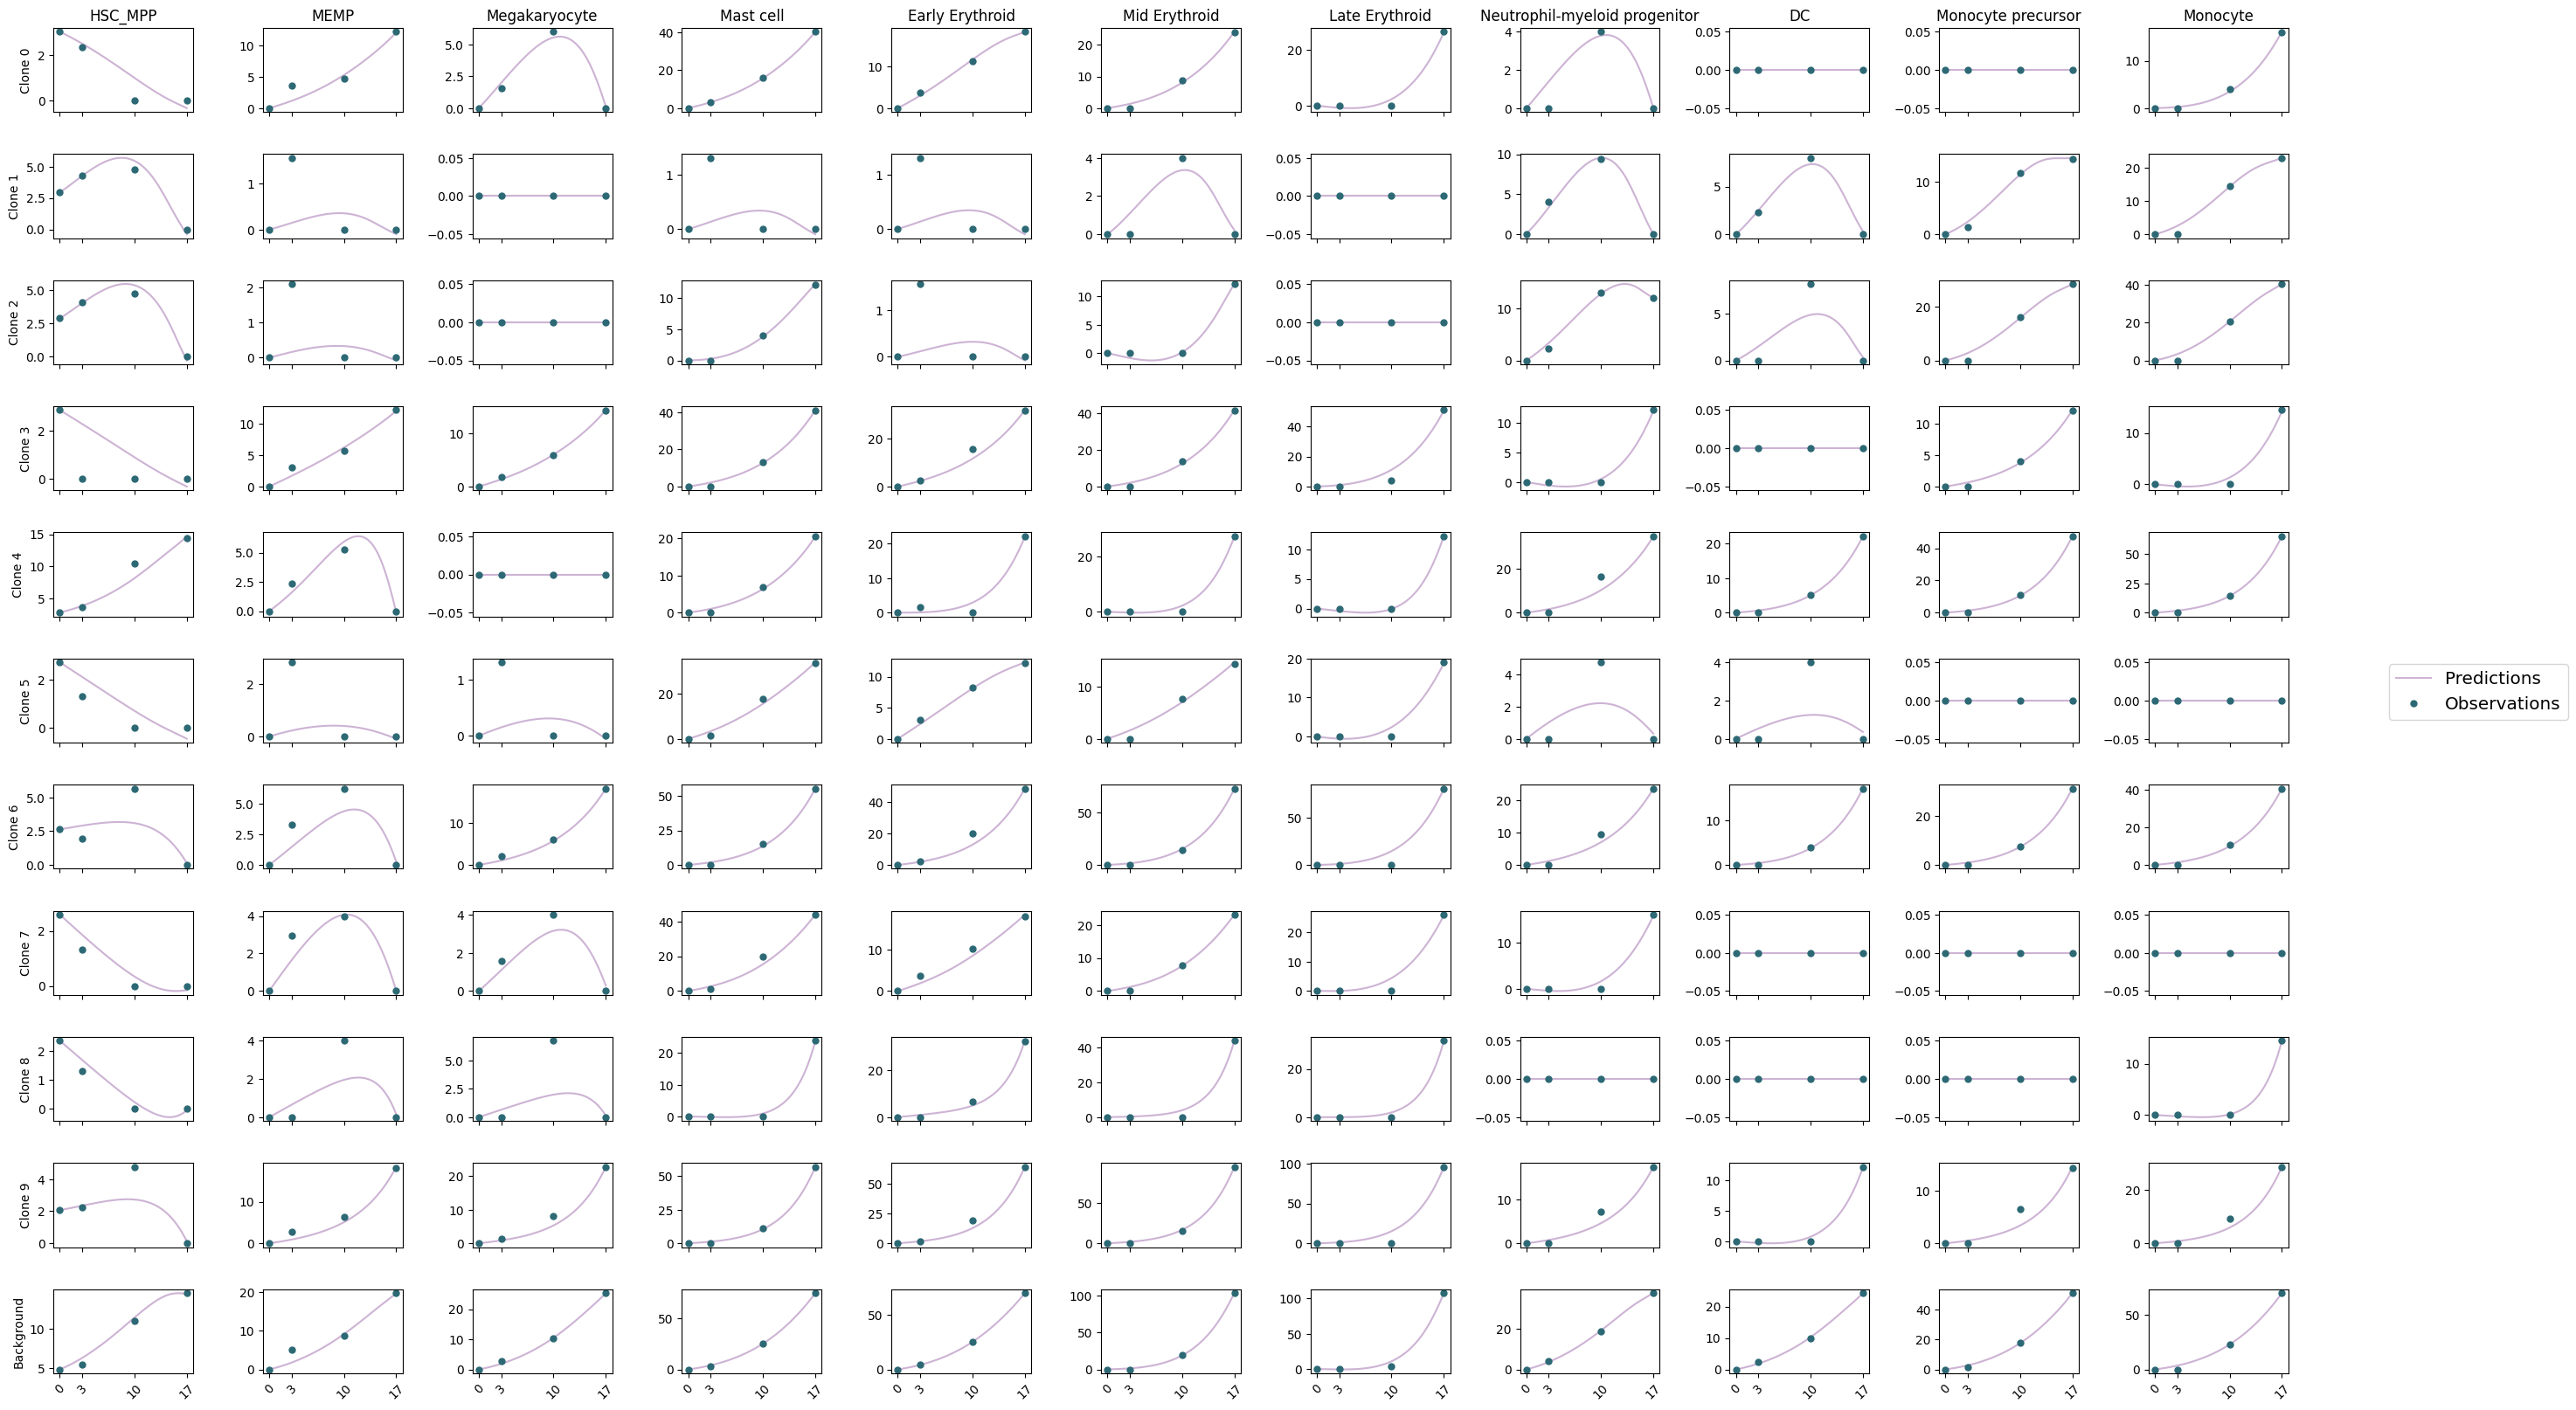

In [7]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.input_N, predictions, t_observed, t_pred, save=False)

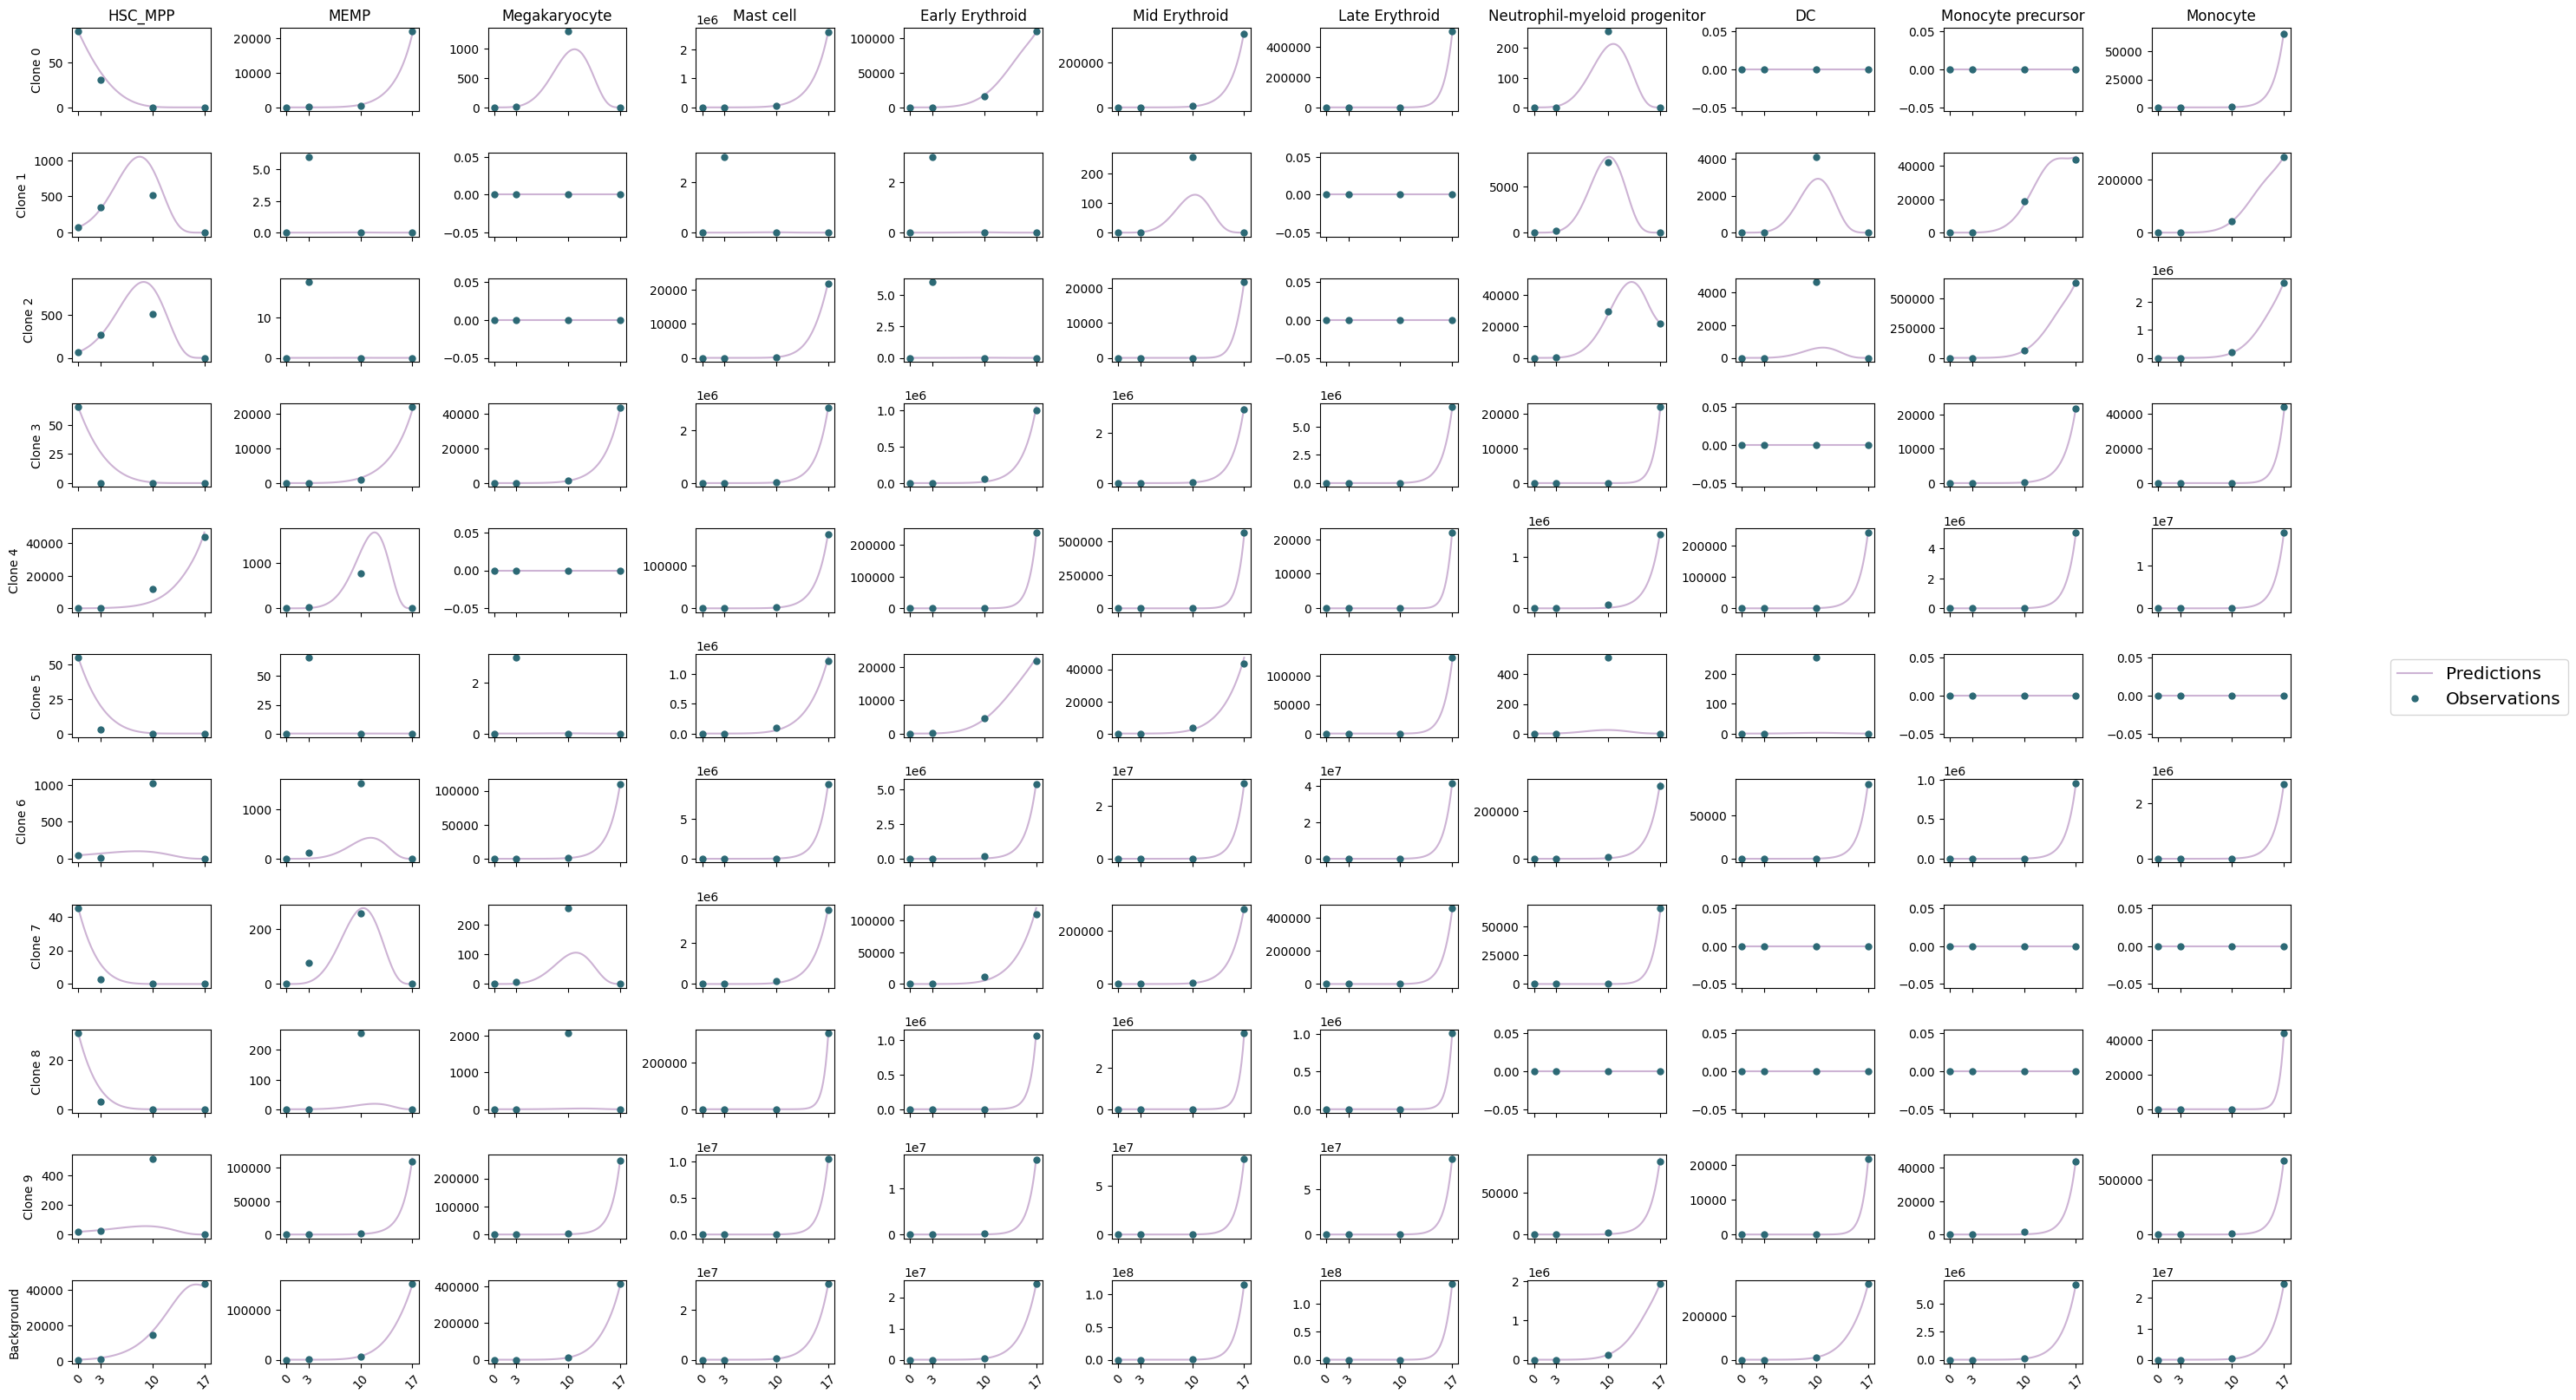

In [8]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.N, torch.pow(predictions, 4), t_observed, t_pred, save=False)

### Constrains on Transition Matrix K

For a 2-layer architecture with Softplus activation function, \
output = input * W1 * W2 if input * W1 aboves a threshold (7) \
output ~ input * W1 * W2 if input * W1 belows the threshold (7) \
And W1 * W2 can be interpreted as transition matrix K linking derivative of y and y itself

Since the input is the power of 1/4, so K_raw ~ K_input * 4 \
And the following analysis is done with this approximation.

In [16]:
K = model.get_matrix_K(eval=True) * 4
anno = pd.read_csv('./data/annotations.csv')

We want 3 constraints
- Entries of K should <= 6 or even more strict <= 4
- Entries of K which aligned with topology L (w/o diagonal info) should strictly >= 0
- Entries of K which not appeared in topology L (except diagonal info) should = 0

3 separate losses are added, with L1 penalty, which seems to be practically better than L2 norm

How to interpret the following arrays, 
- 1st row -> id of clones
- 2nd row -> id of source population
- 3rd row -> id of target population

In [26]:
utils.validate_K(model)

# of entries where transition rates > 6.0: 0
[] 

# of entries where transition rates > 4.0: 23
[[ 0  1  1  2  2  3  4  4  4  5  5  5  6  6  7  7  8  9  9 10 10 10 10]
 [ 0  0  7  0  0  0  0  0  0  0  5  6  0  0  0  1  4  0  0  0  0  0  5]
 [ 7  7 10  0  7  1  0  1  7  7  6  6  1  7  1  3  5  1  7  0  1  7  6]] 

# of non-diagonal entries < 0 among all clones: 0
[] 

All other entries not in topology graph L should be as close to 0 as possible, ideally strictly equals to 0.
# of entries: 1089.0
Max: 0.000153, Median: -0.000000, Min: -0.000136


Distribution of entries' value of constraint #3, and an example from clone #1 is illustrated. 

<AxesSubplot: ylabel='Count'>

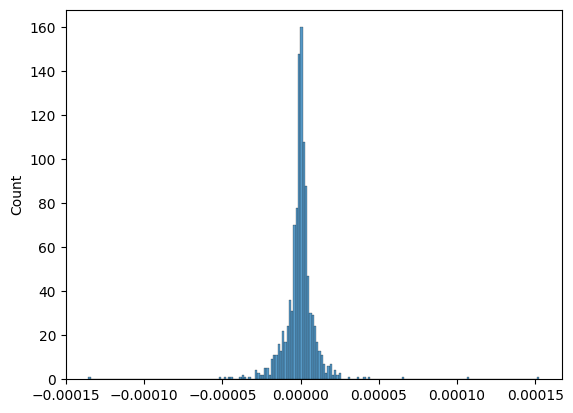

In [27]:
import seaborn as sns
# K = (model.get_matrix_K(eval=True) * 4).detach().cpu().numpy()
oppo_mask = model.oppo_L.cpu().numpy()
oppo = K.detach().cpu().numpy() * oppo_mask
sns.histplot(oppo[np.where(oppo != 0)], bins=200)

Origianl matrix K for clone #1, with and without masks.

<AxesSubplot: >

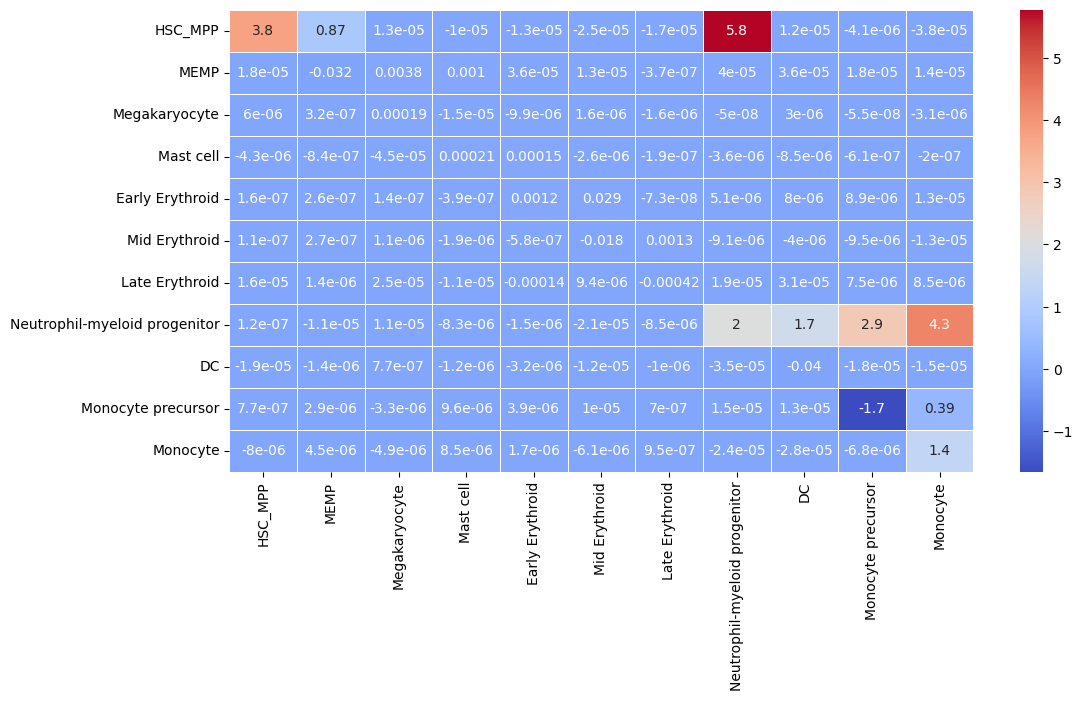

In [28]:
transition_K = pd.DataFrame(
    index=anno['populations'].values, 
    columns=anno['populations'].values, 
    data=K.detach().cpu().numpy()[1]
)
fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(transition_K, annot=True, linewidths=.5, cmap='coolwarm', ax=axes)

<AxesSubplot: >

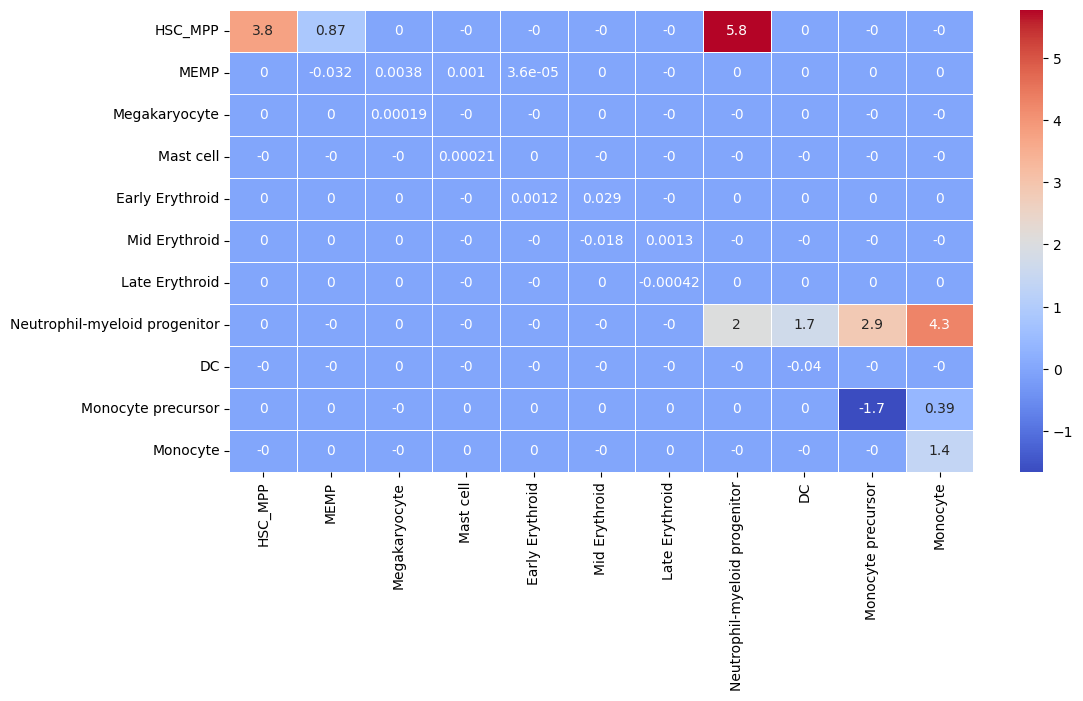

In [24]:
transition_K = pd.DataFrame(
    index=anno['populations'].values, 
    columns=anno['populations'].values, 
    data=(K * model.used_L).detach().cpu().numpy()[1]
)
fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(transition_K, annot=True, linewidths=.5, cmap='coolwarm', ax=axes)